In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stt 
import scipy as sp 
import seaborn as sns

from scipy.io import loadmat

from statsmodels.graphics import tsaplots
from statsmodels.tsa.ar_model import AutoReg

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)

from xgboost import XGBClassifier

#plot_settings = {'font.weight' : 'bold',
#        'font.size'   : 22,
#        'figure.figsize': (21,21)}
#plt.rcParams.update(plot_settings)
plt.rcParams.update({'figure.figsize':(10,10)})
plt.style.use('seaborn-colorblind')

# Feature Extraction 

Let's start by loading the timeseries and taking a look at some of its basic properties. Once some basic quality control has been done, we can calculate our feature of interest the autocorrelation of a set of timeseries. These timeseries represent activation in regions of the brain over $4$ resting state scans.


In [2]:
mat_contents=loadmat('../Data/Glaser_ts.mat') # load .mat file with timeseries in the Glaser Parcellation
print(mat_contents.keys()) #looking for ts_mat which is number of regions by number of timepoints by number of subjects

dict_keys(['__header__', '__version__', '__globals__', 'ts_mat'])


In [3]:
Time_Series_Matrix=mat_contents['ts_mat']
print(f'Time Series is stored in a {type(Time_Series_Matrix)}')
print(f'With shape {Time_Series_Matrix.shape}')
print(f'and element type {Time_Series_Matrix.dtype}')


num_Subj=Time_Series_Matrix.shape[2] # number of subjects
num_Regions=Time_Series_Matrix.shape[0] 
num_Timepoints=Time_Series_Matrix.shape[1]

Time Series is stored in a <class 'numpy.ndarray'>
With shape (360, 1680, 200)
and element type float64


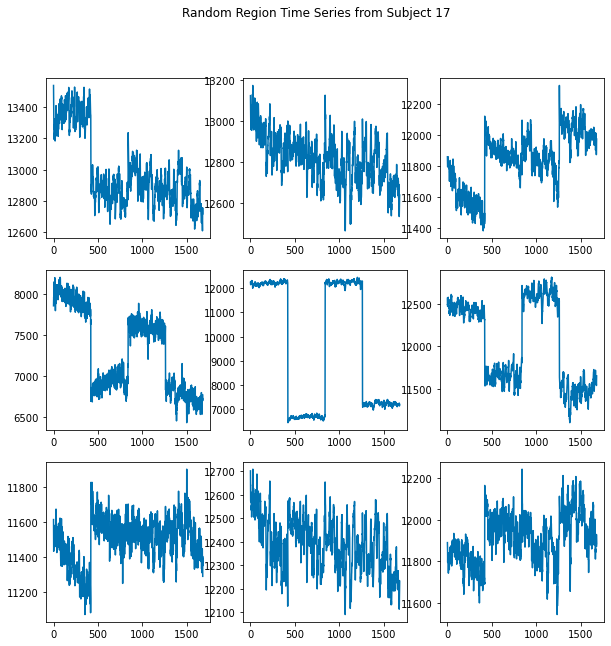

In [4]:
# Basic Visual Inspection of data

rng = np.random.default_rng() #random generator to do selection
x=np.arange(num_Timepoints)
#Plot regions from the same (random) subject
x_lim=3
y_lim=3 
num_subplots=x_lim*y_lim #set number of subplots 
plot_subject=rng.integers(num_Subj)
plot_regions=rng.integers(num_Regions,size=(num_subplots,1))
for ts_ind in range(num_subplots):
    plt.subplot(x_lim,y_lim,ts_ind+1)
    plt.plot(x,Time_Series_Matrix[plot_regions[ts_ind],:,plot_subject].transpose())
plt.suptitle('Random Region Time Series from Subject {}'.format(plot_subject))
plt.show()

## Standardizing each time series

The discontinuity behavior in the scans comes from the fact that this isn't one timeseries, but is instead $4$ timeseries concatenated. To deal with the differences between each of the $4$ scans let's standardize (mean center the divide by the standard deviation) the timeseries by scan. There are of course other things which might make sense to do here, for example calculating autocorrelation or removing time based trends from each time series seperately . However, standardizing each timeseries and treating the $4$ scans as $1$ is closer to the standard in the neuroscience literature literature so we'll stick with that. 


In [5]:
scan_length=num_Timepoints//4

Time_Series_Matrix_standard=np.zeros(Time_Series_Matrix.shape)
for reg_ind in range(num_Regions):
    for scan_ind in range(0,num_Timepoints,scan_length):
        for sub_ind in range(num_Subj):
            scan_ts=Time_Series_Matrix[reg_ind,scan_ind:scan_ind+scan_length,sub_ind]
            Time_Series_Matrix_standard[reg_ind,scan_ind:scan_ind+scan_length,sub_ind]=(scan_ts-np.mean(scan_ts))/np.std(scan_ts)


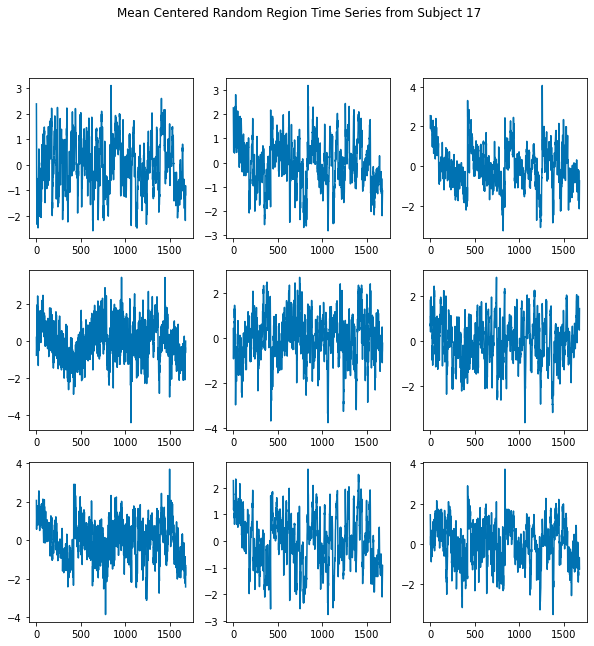

In [6]:
for ts_ind in range(num_subplots):
    plt.subplot(x_lim,y_lim,ts_ind+1)
    plt.plot(x,Time_Series_Matrix_standard[plot_regions[ts_ind],:,plot_subject].transpose())
plt.suptitle('Mean Centered Random Region Time Series from Subject {}'.format(plot_subject))
plt.show()

These look at least a little better. Following past work, let's consider the autocorrelation at lag $1$ as our feature of interest for each subject. However, before we dive into that more deeply let's see if that's a reasonable way to think about these time series. 


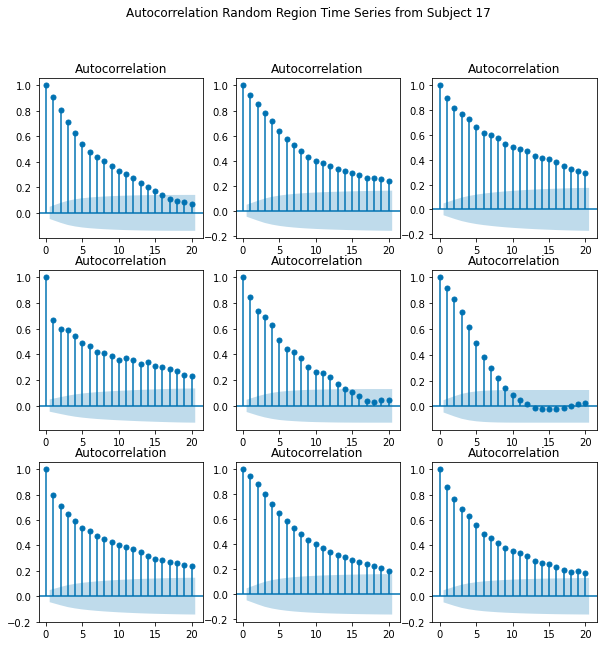

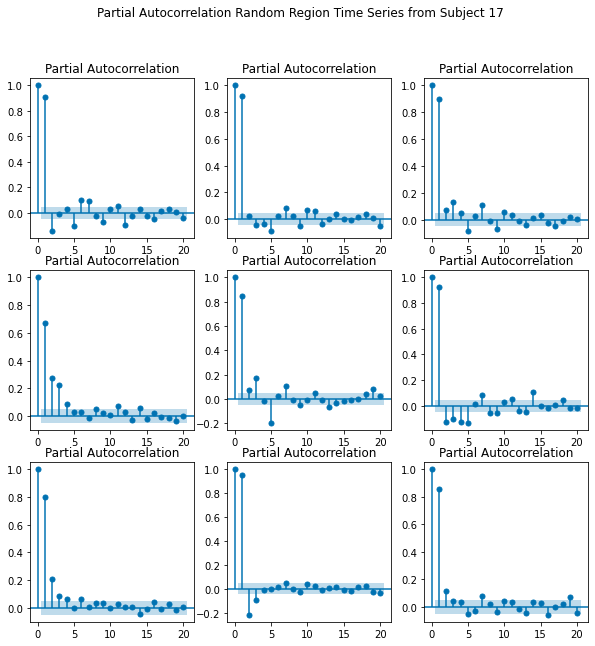

In [7]:
num_lags=20
for ts_ind in range(num_subplots):
    axis=plt.subplot(x_lim,y_lim,ts_ind+1)
    tsaplots.plot_acf(Time_Series_Matrix_standard[plot_regions[ts_ind],:,plot_subject].transpose(),ax=axis, lags=num_lags)
plt.suptitle('Autocorrelation Random Region Time Series from Subject {}'.format(plot_subject))
plt.show()

for ts_ind in range(num_subplots):
    axis=plt.subplot(x_lim,y_lim,ts_ind+1)
    tsaplots.plot_pacf(Time_Series_Matrix_standard[plot_regions[ts_ind],:,plot_subject].transpose(),ax=axis, lags=num_lags)
plt.suptitle('Partial Autocorrelation Random Region Time Series from Subject {}'.format(plot_subject))
plt.show()

In [8]:
#save for plotting later
np.save('../data/Standardized_Time_Series.npy',Time_Series_Matrix_standard)


The autocorrelation plots show that there's a significant degree of autocorrelation, in some cases up to num_lags, however we can see from the partial autocorrelation function that a great deal of the autocorrelation is mediated by the lag $1$ timeseries. In an ideal world, I'd probably fit a higher order autoregressive model to these data but based on these plots and for the sake of matching the literature using a lag of $1$ seems reasonable for these data. 

In [31]:
Autocorrelation_array=np.zeros((num_Regions,num_Subj))
for reg_ind in range(num_Regions):
    for sub_ind in range(num_Subj):
        ar_model=AutoReg(Time_Series_Matrix_standard[reg_ind,:,sub_ind],lags=1).fit()
        Autocorrelation_array[reg_ind,sub_ind]=ar_model.params[1] #ar_model has two params, a constant term (params[0]) and the coefficient for lag 1 (params [1])

'''
 Just in case something a little more sophisticated needs to be done in the future. 
The next step towards a more appropriate handling of the time series is to call 
ar_model=ar_select_order(data,maxlag=20).model.fit() #searches for the optimal model order up to 20 lags 
and then select the appropriate lag. The thing to watch out for here is that if lag 1 isn't optimal it won't be calculated in this method, so there would need to be a check that optimal order includes lag 1. To do that you can split the call into 
mod=ar_select_order(data,maxlag=20) 
ar_model=mod.model.fit()
and check 
mod.ar_lags #the optimal lags for the model
'''

"\n Just in case something a little more sophisticated needs to be done in the future. \nThe next step towards a more appropriate hangling of the time series is to call \nar_model=ar_select_order(data,maxlag=20).model.fit() #searches for the optimal model order up to 20 lags \nand then select the appropriate lag. The thing to watch out for here is that if lag 1 isn't optimal it won't be calculated in this method, so there would need to be a check that optimal order includes lag 1. To do that you can split the call into \nmod=ar_select_order(data,maxlag=20) \nar_model=mod.model.fit()\nand check \nmod.ar_lags #the optimal lags for the model\n"

# Load Network Features 

In order to compare the performance of the autocorrelation as a feature of interest, I'm going to load a set of network features which will be used to train a comparison classifier. I have three network featuers of interest, the positive nodal strenght, the negative nodal strength, and the signed clustering coefficient. These were calculated using functions from the Brain Connectivity Toolbox in Matlab, specifically strength_und_sign for the strengths and clustering_coef_wu_sign method $3$ for the clustering coefficient. 


In [32]:
network_mat=loadmat('../Data/Network_Measures.mat') # load .mat file with timeseries in the Glaser Parcellation
print(network_mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'cc', 'neg', 'pos'])


In [33]:
pos_str=network_mat['pos']
neg_str=network_mat['neg']
clus_co=network_mat['cc']

In [34]:
# Probably should do some preliminary data checks here
print(f'Autocorrelation features are {Autocorrelation_array.shape}')
print(f'Network features are {pos_str.shape}')

Autocorrelation features are (360, 200)
Network features are (360, 200)


# Load Labels
Now that we have the autocorrelation at lag $1$, let's see if it's useful for differentiating our subjects with depression/anxiety vs those without. Let's load the labels and take a look at the distributions. 

In [35]:
label_dict=loadmat('../Data/All_inds.mat')

print(label_dict.keys()) #all_inds has the labels for depression etc

dict_keys(['__header__', '__version__', '__globals__', 'all_inds'])


In [36]:
Labels=label_dict['all_inds'].flatten()
print(Labels[:20])
# Labels are 1, control 2, anxious 3 depressed and comorbid anxious/depressed

[1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 3 1 2 2 3]


In [37]:
Counts=np.bincount(Labels)
print(f'There are {Counts[1]} Controls, {Counts[2]} Anxious, and {Counts[3]} Depressed')

There are 63 Controls, 64 Anxious, and 73 Depressed


In [38]:
Two_Class_Labels=(Labels>1).astype(int) #for preliminary analysis we'll consider anxious and depressed patients as a patient group
print(Two_Class_Labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0
 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1
 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1
 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


# Hypothesis-based Dimensionality Reduction
Now that we have our class labels and our feature vector, let's see if we can find any differences between the classes based on our features. Since we have more features than subjects, let's consider a few way to reduce the dimensionality of our feature vector. The first two will involve specific hypotheses that come from the literature. The first hypothesis is that the Subgenual Anterior Cingulate Cortex (sg-ACC) is important in depression. In the Glasser atlas the sg-ACC is covered by $6$ nodes, which are the right and left a24, 25, and s25 regions.  The second is that we'd expect to see differences throughout the default mode network (DMN). 

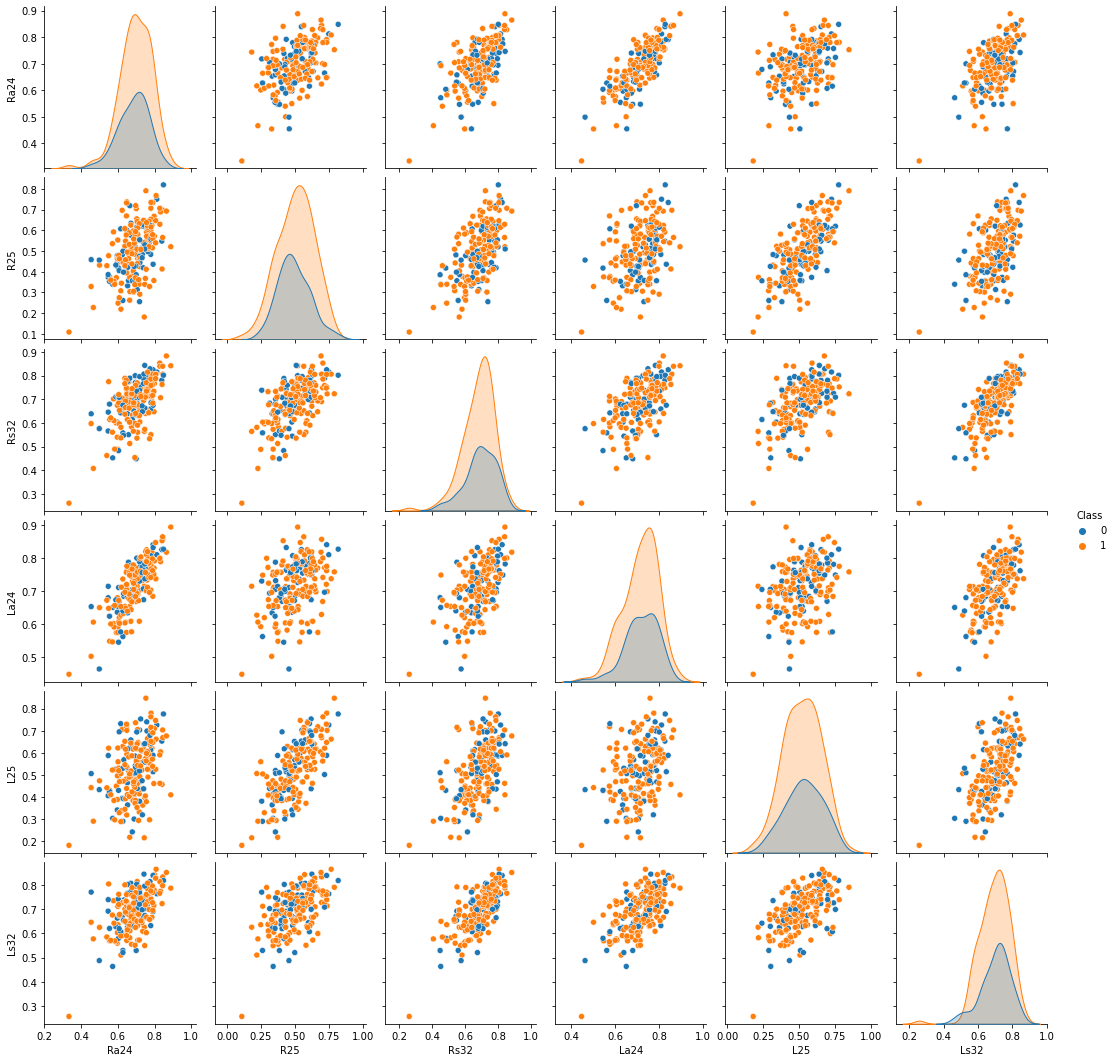

In [39]:
Nodes_Of_Interest={'Ra24':61,'R25':164,'Rs32':165,'La24':241,'L25':344,'Ls32':345} # dictionary with node names and the parcel number in the Glasser Atlas
num_noi=len(Nodes_Of_Interest)
noi_features=np.zeros((num_noi,num_Subj))
noi_features=Autocorrelation_array[[val-1 for val in Nodes_Of_Interest.values()],:].transpose()
noi_dataframe=pd.DataFrame(noi_features,columns=[val for val in Nodes_Of_Interest.keys()])
noi_dataframe['Class']=Two_Class_Labels
sns.pairplot(noi_dataframe,hue='Class') #do some pairplots while we still have a relatively low dimensional feature


Based on the pairplot, outside of a few outliers these features are highly co-linear and I probably wouldn't expect much luck with a classifier. Of course that's not too unexpected because these timeseries are for regions that are right next to each other in the brain. Let's just double check a non-linear dimensionality reduction to be sure. 

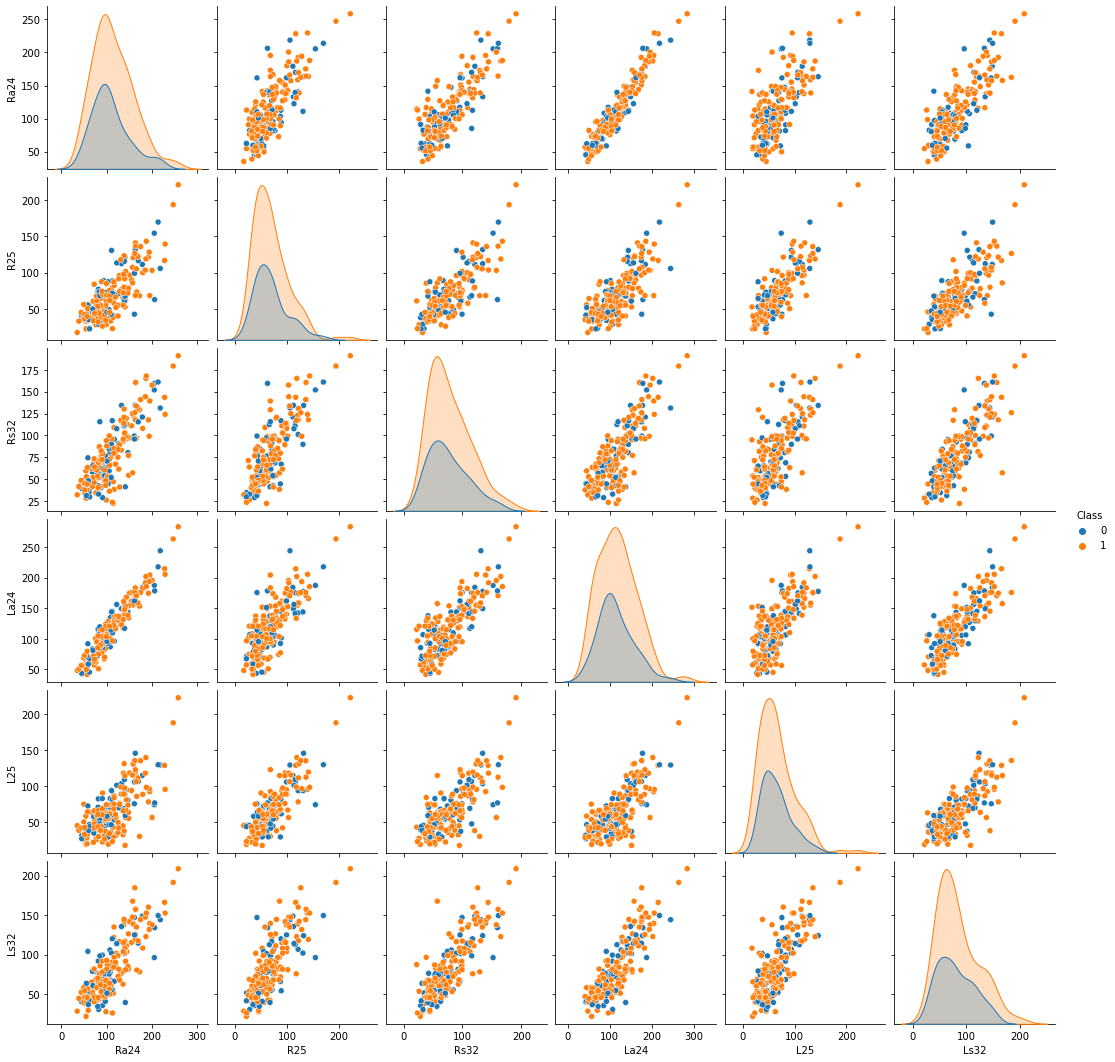

In [40]:
#Let's compare this to the network based features
noi_feat_pos=np.zeros((num_noi,num_Subj))
noi_feat_pos=pos_str[[val-1 for val in Nodes_Of_Interest.values()],:].transpose()
noi_df_pos=pd.DataFrame(noi_feat_pos,columns=[val for val in Nodes_Of_Interest.keys()])
noi_df_pos['Class']=Two_Class_Labels
sns.pairplot(noi_df_pos,hue='Class')



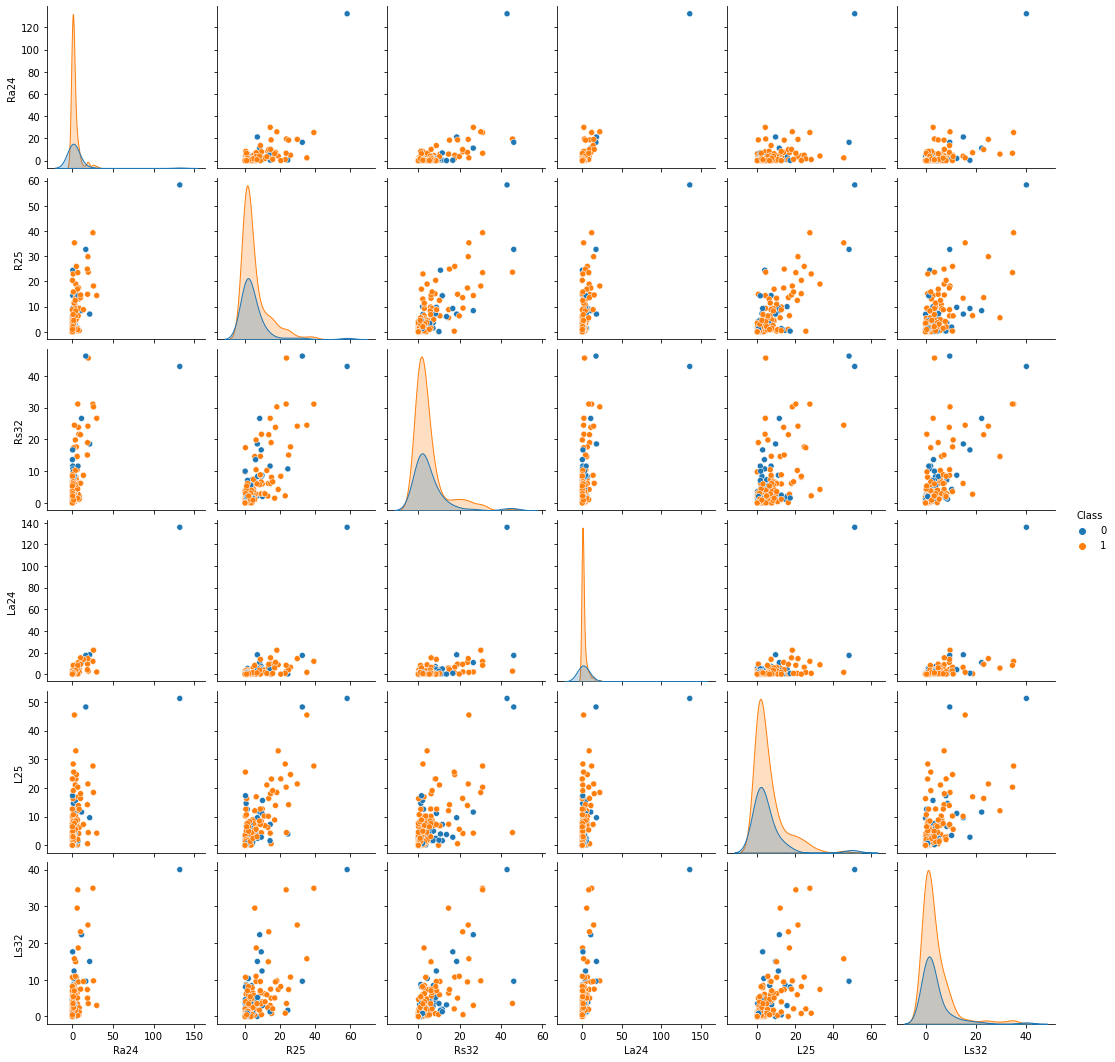

In [41]:
noi_feat_neg=np.zeros((num_noi,num_Subj))
noi_feat_neg=neg_str[[val-1 for val in Nodes_Of_Interest.values()],:].transpose()
noi_df_neg=pd.DataFrame(noi_feat_neg,columns=[val for val in Nodes_Of_Interest.keys()])
noi_df_neg['Class']=Two_Class_Labels
sns.pairplot(noi_df_neg,hue='Class')

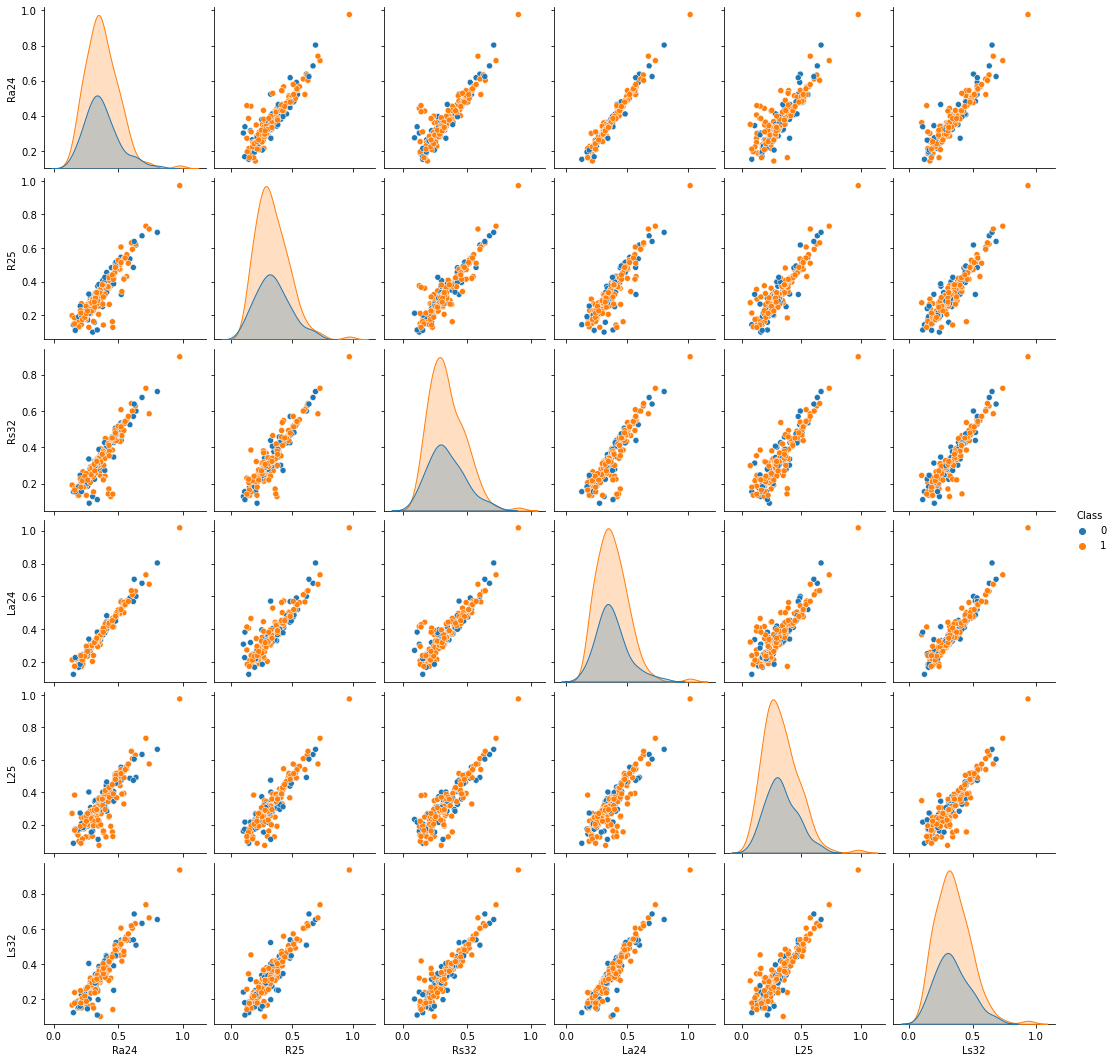

In [42]:
noi_feat_cc=np.zeros((num_noi,num_Subj))
noi_feat_cc=clus_co[[val-1 for val in Nodes_Of_Interest.values()],:].transpose()
noi_df_cc=pd.DataFrame(noi_feat_cc,columns=[val for val in Nodes_Of_Interest.keys()])
noi_df_cc['Class']=Two_Class_Labels
sns.pairplot(noi_df_cc,hue='Class')

There are some really interesting patterns in the network features compared to the autocorrlation features. There's very strong laterality, i.e. the left right pairs of a given node generate features that are highly co-linear.  

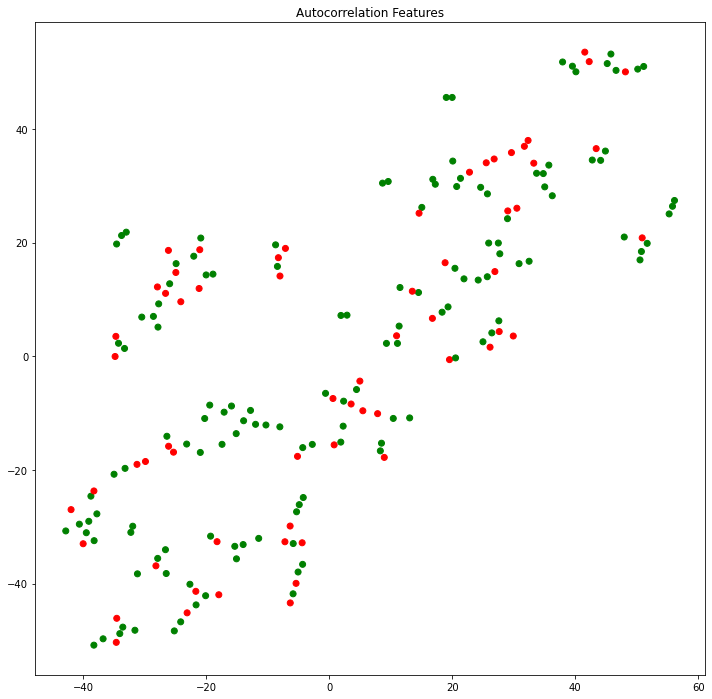

In [43]:
# do some TSNE visualization

noi_embedded=TSNE(n_components=2,perplexity=5).fit_transform(noi_features) #tried various perplexities (5,10,15,30,50,100) at perplexities higher than 5 the points seem linearly correlated with no class distinctions and at high perplexities (100) the points seem randomly distributed. 
colormap = np.array(['r', 'g','b'])

plt.scatter(noi_embedded[:,0],noi_embedded[:,1],c=colormap[Two_Class_Labels])
plt.title('Autocorrelation Features')
plt.show()


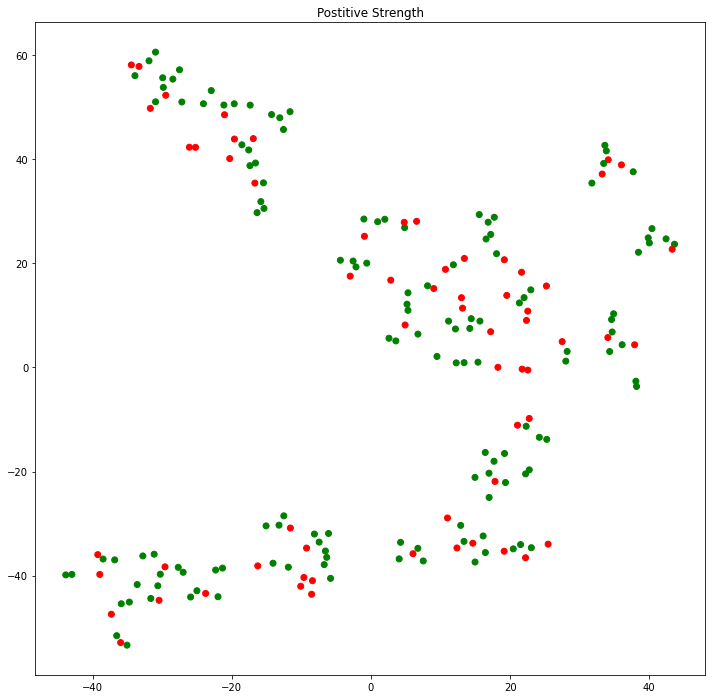

In [44]:
noi_embedded=TSNE(n_components=2,perplexity=5).fit_transform(noi_feat_pos) #tried various perplexities (5,10,15,30,50,100) at perplexities higher than 5 the points seem linearly correlated with no class distinctions and at high perplexities (100) the points seem randomly distributed. 
colormap = np.array(['r', 'g','b'])

plt.scatter(noi_embedded[:,0],noi_embedded[:,1],c=colormap[Two_Class_Labels])
plt.title('Postitive Strength')
plt.show()


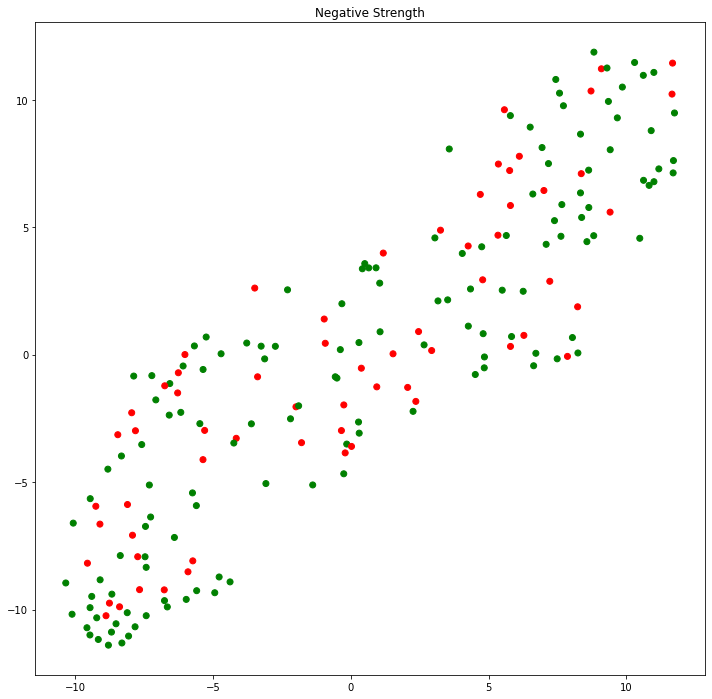

In [45]:
noi_embedded=TSNE(n_components=2,perplexity=30).fit_transform(noi_feat_neg) #tried various perplexities (5,10,15,30,50,100), seems like this is a feature set where there's a bit of hope in identifying patients

colormap = np.array(['r', 'g','b'])

plt.scatter(noi_embedded[:,0],noi_embedded[:,1],c=colormap[Two_Class_Labels])
plt.title('Negative Strength')

plt.show()


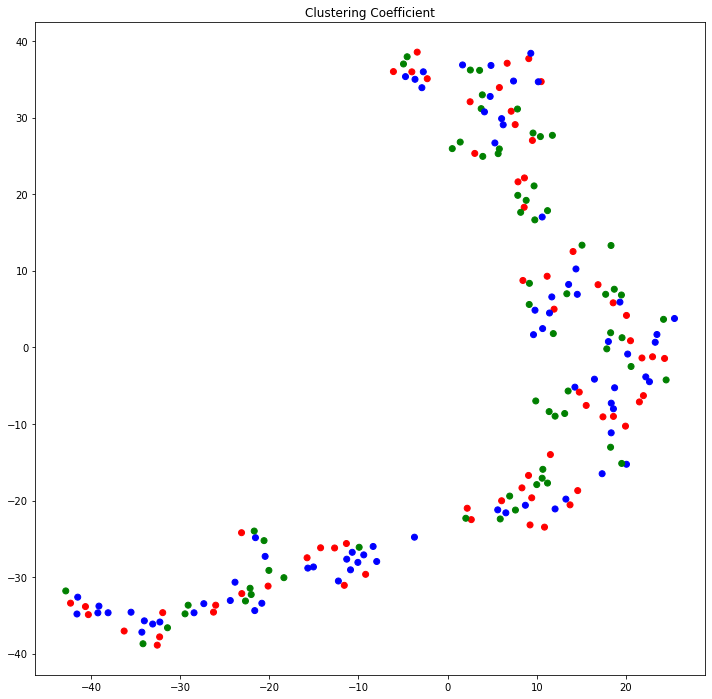

In [46]:
noi_embedded=TSNE(n_components=2,perplexity=10).fit_transform(noi_feat_cc) #tried various perplexities (5,10,15,30,50,100) at perplexities higher than 15 the points seem linearly correlated with no class distinctions and at high perplexities (100) the points seem randomly distributed. There's interesting behavior ar perp 5, there seems to be a smaller clusters of subjects but which don't match patient labels well. At perp 10, there's a two group split though it also doesn't match the group labels. 

colormap = np.array(['r', 'g','b'])

plt.scatter(noi_embedded[:,0],noi_embedded[:,1],c=colormap[Labels-1])
plt.title('Clustering Coefficient')
plt.show()

Based on the pairplots and the TSNE plots, I wouldn't expect a classifier to do particularly well with this set of features. Let's move on to the next set of features to see whether that will give us a better shot. Let's consider what happens when we look at the nodes in the default mode network. 

In [47]:
#load network labels
network_labels_dict=loadmat('../Data/cortex_parcel_network_assignments.mat')
print(network_labels_dict.keys())

dict_keys(['__header__', '__version__', '__globals__', 'netassignments'])


In [48]:
Net_labels=network_labels_dict['netassignments'].flatten()
num_in_dmn=np.bincount(Net_labels)[9] #network_labelfile.txt has how the network number corresponds to the network name. For DMN we are looking for Net_labels==9

print(f'Number of Nodes in DMN is {num_in_dmn}') 


Number of Nodes in DMN is 77


In [49]:
#select autocorrelation from DMN
DMN_features=np.zeros((num_in_dmn,num_Subj))
DMN_features=Autocorrelation_array[Net_labels.flatten()==9,:].transpose()
DMN_features.shape


(200, 77)

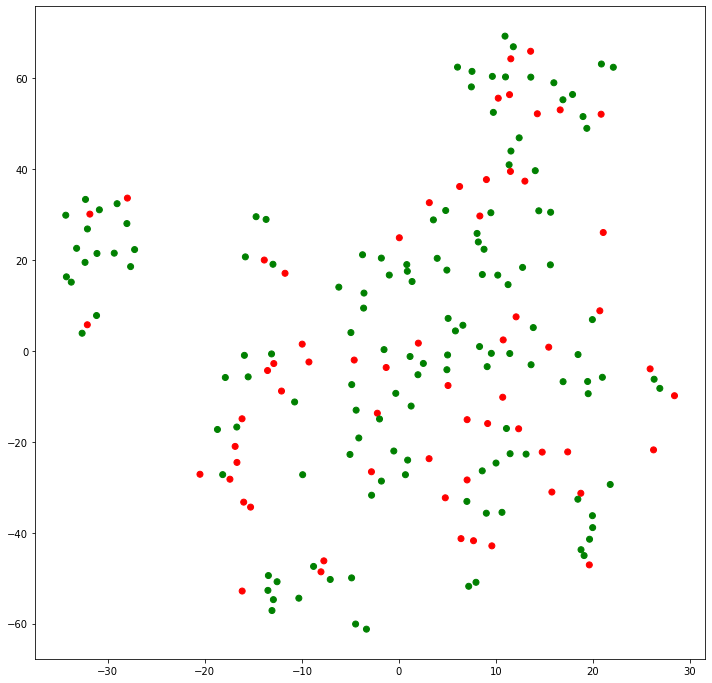

In [50]:

DMN_embedded=TSNE(n_components=2,perplexity=5).fit_transform(DMN_features) #tried various perplexities (5,10,15,30,50,100) at perplexities higher than 5 the points seem linearly correlated with no class distinctions and at high perplexities (100) the points seem randomly distributed. 
colormap = np.array(['r', 'g','b'])

plt.scatter(DMN_embedded[:,0],DMN_embedded[:,1],c=colormap[Two_Class_Labels])
plt.show()

Based on this TSNE plot I'm not super confident that a classifier will work based on autocorrelation values in the DMN. I'm going to also look at the TSNE plot for the whole set of features.

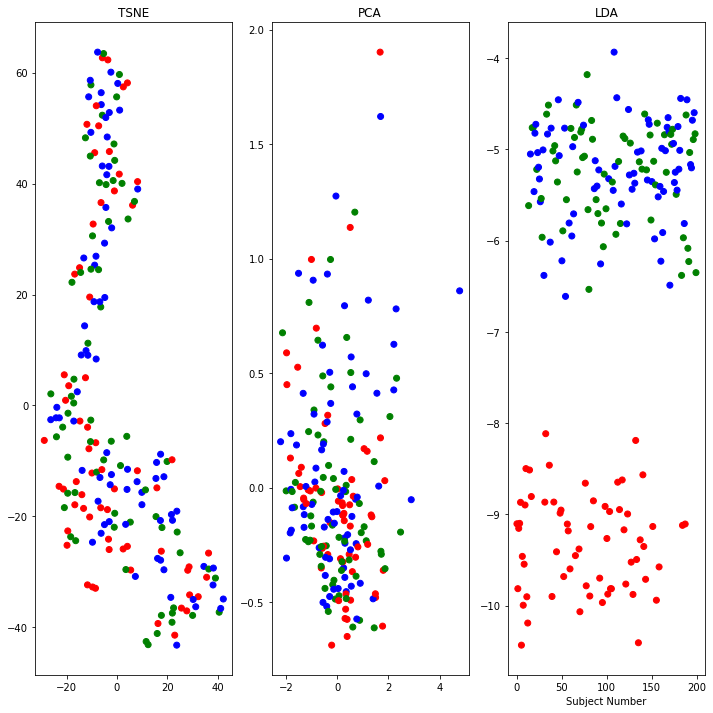

In [51]:
Auto_embedded_TSNE=TSNE(n_components=2,perplexity=5).fit_transform(Autocorrelation_array.transpose()) #tried various perplexities (5,10,15,30,50,100) at perplexities higher than 5 the points seem linearly correlated with no class distinctions and at high perplexities (100) the points seem randomly distributed. 
Auto_embedded_PCA=PCA(n_components=2).fit_transform(Autocorrelation_array.transpose())
LDA=LinearDiscriminantAnalysis(solver='eigen',shrinkage='auto')
Auto_embedded_LDA=LDA.fit_transform(Autocorrelation_array.transpose(),Two_Class_Labels) #will automatically produce one dimensional output because n_classes=2

Auto_embedded_LDA.shape
colormap = np.array(['r', 'g','b'])
plt.subplot(1,3,1)
plt.scatter(Auto_embedded_TSNE[:,0],Auto_embedded_TSNE[:,1],c=colormap[Labels-1])
plt.title("TSNE")
plt.subplot(1,3,2)
plt.scatter(Auto_embedded_PCA[:,0],Auto_embedded_PCA[:,1],c=colormap[Labels-1])
plt.title("PCA")
plt.subplot(1,3,3)
plt.scatter([val for val in range(len(Auto_embedded_LDA))],Auto_embedded_LDA,c=colormap[Labels-1])
plt.title("LDA")
plt.xlabel('Subject Number')
plt.show()

# Classifier Selection 

Comparing multiple dimensionality reduction techniques on the full dataset, it seems that it might be possible to find a linear classifier that seperates these classes.  I'm going to give two basic classifiers a shot on both the full data and the DMN subset. However, since I have only $200$ samples I'm going to need to do some unsupervised dimensionality reduction on the full set of autocorrelation values. 

In [136]:
X=np.concatenate((Autocorrelation_array,pos_str,neg_str,clus_co),axis=0).transpose() # sets up correctly for scikit learn input later


#do model selection based on a test train split
X_train, X_test, y_train, y_test = train_test_split(X, Two_Class_Labels, test_size=.20, random_state=42,stratify=Two_Class_Labels)

CV=StratifiedKFold(n_splits=10,random_state=42)
scale=StandardScaler()
X_train_sc=scale.fit_transform(X_train)
X_test_sc=scale.transform(X_test)

num_components=[4,6,8,10,12]
svc_kernels=['linear','rbf']
svc_reg=[.1,1,10,100, 1000] 
depths=[1,3,5,7]

pipe_svc=Pipeline([('svc', SVC())])
param_grid_svc = {'svc__kernel': svc_kernels,'svc__C': svc_reg }

pipe_XGB=Pipeline([('XGB',XGBClassifier(use_label_encoder=False,eval_metric='logloss'))])
param_grid_XGB = {'XGB__objective': ['binary:logistic'],'XGB__max_depth':depths }

pipe_pca_svc=Pipeline([('pca',PCA()), ('svc', SVC())])
param_grid_pca_svc = {'pca__n_components':num_components,'svc__kernel': svc_kernels,'svc__C':svc_reg }

pipe_pca_XGB=Pipeline([('scaler', StandardScaler()),('pca',PCA()), ('XGB',XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])
param_grid_pca_XGB = {'pca__n_components':num_components,'XGB__objective': ['binary:logistic'],'XGB__max_depth':depths}

pipe_MI_svc=Pipeline([('scaler', StandardScaler()),('MI',SelectKBest(mutual_info_classif)), ('svc', SVC())])
param_grid_MI_svc = {'MI__k':num_components,'svc__kernel': svc_kernels,'svc__C':svc_reg }

pipe_MI_XGB=Pipeline([('MI',SelectKBest(mutual_info_classif)), ('XGB',XGBClassifier(use_label_encoder=False,eval_metric='logloss'))])
param_grid_MI_XGB = {'MI__k':num_components,'XGB__objective': ['binary:logistic'],'XGB__max_depth':depths}

pipelines=[pipe_svc,pipe_XGB,pipe_pca_svc,pipe_pca_XGB,pipe_MI_svc,pipe_MI_XGB]
params=[param_grid_svc,param_grid_XGB,param_grid_pca_svc,param_grid_pca_XGB,param_grid_MI_svc,param_grid_MI_XGB]
names=['SVC','XGB','PCA_SVC','PCA_XGB','MI_SVC','MI_XGB']
scoring = {'Acc': 'accuracy', 'Bal_Acc': 'balanced_accuracy'} 
feat_names=['Auto','Pos','Neg','CC']

#pipe_knn=Pipeline([('nca', NeighborhoodComponentsAnalysis()), ('knn', KNeighborsClassifier())])
#param_grid_knn={'nca__n_components':[5,10,15,20,None],'knn__n_neighbors': [1,2,3,5,10]}

In [137]:
def jackknife_variance(X,y,model):
    ''' Returns an estimate of the variance of the fit of classification model on (X,y) using jackknife resampling
    '''
    S=list()
    n=len(y)
    for ind in range(0,n):
        Samples=np.delete(X,ind,axis=0)
        Labels=np.delete(y,ind,axis=0)
        S.append(model.score(Samples,Labels))
    return (n-1)*np.var(S)
    



In [138]:
All_feat_test=list()
All_feat_test_jack=list()
for pipe, param, name in zip(pipelines,params,names):
    print(f'Classifier Evaluation for {name}')
    search=GridSearchCV(estimator=pipe,param_grid=param,scoring=scoring,refit='Bal_Acc',cv=CV)
    search.fit(X_train_sc, y_train)
    All_feat_test.append(search.score(X_test_sc, y_test))
    All_feat_test_jack.append(jackknife_variance(X_test_sc,y_test,search))
    print(f'For all features')
    print(f'Best score on training data is {search.best_score_}')
    print(f'Using a classifier with the following parameters {search.best_estimator_} \n')
    print(f'On the test set the classifier has an accuracy of {All_feat_test[-1]} with variance {All_feat_test_jack[-1]} and the following report \n')
    print(classification_report(y_test,search.predict(X_test_sc)))



Classifier Evaluation for SVC
For all features
Best score on training data is 0.5509090909090908
Using a classifier with the following parameters Pipeline(steps=[('svc', SVC(C=10))]) 

On the test set the classifier has an accuracy of 0.5028490028490029 with variance 0.004093215811965806 and the following report 

              precision    recall  f1-score   support

           0       0.33      0.15      0.21        13
           1       0.68      0.85      0.75        27

    accuracy                           0.62        40
   macro avg       0.50      0.50      0.48        40
weighted avg       0.56      0.62      0.58        40

Classifier Evaluation for XGB
For all features
Best score on training data is 0.5063636363636363
Using a classifier with the following parameters Pipeline(steps=[('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1,

In [139]:
n_pipes=len(pipelines)
Est_acc_ind_feat=np.empty((n_pipes,4))
Est_var_ind_feat=np.empty((n_pipes,4))
for i, (pipe, param, name) in enumerate(zip(pipelines,params,names)):
    print(f'Classifier Evaluation for {name}')
    ind=0 # this isn't pretty from a code efficiency stand point but for now it helps see my outputs
    X_train_sub=X_train_sc[:,ind*num_Regions:(ind+1)*num_Regions]
    X_test_sub=X_test_sc[:,ind*num_Regions:(ind+1)*num_Regions]
    search=GridSearchCV(estimator=pipe,param_grid=param,scoring=scoring,refit='Bal_Acc',cv=CV)
    search.fit(X_train_sub, y_train)
    Est_acc_ind_feat[i,ind]=search.score(X_test_sub, y_test)
    Est_var_ind_feat[i,ind]=jackknife_variance(X_test_sub,y_test,search)

    print(f'For features {feat_names[ind]}')
    print(f'Best score on training data is {search.best_score_}')
    print(f'Using a classifier with the following parameters {search.best_estimator_} \n')
    print(f'On the test set the classifier has an accuracy of {Est_acc_ind_feat[i,ind]} with variance {Est_var_ind_feat[i,ind]} and the following report \n')
    print(classification_report(y_test,search.predict(X_test_sub)))

Classifier Evaluation for SVC
For features Auto
Best score on training data is 0.5527272727272727
Using a classifier with the following parameters Pipeline(steps=[('svc', SVC(C=10))]) 

On the test set the classifier has an accuracy of 0.5398860398860399 with variance 0.003532318376068366 and the following report 

              precision    recall  f1-score   support

           0       0.50      0.15      0.24        13
           1       0.69      0.93      0.79        27

    accuracy                           0.68        40
   macro avg       0.60      0.54      0.51        40
weighted avg       0.63      0.68      0.61        40

Classifier Evaluation for XGB
For features Auto
Best score on training data is 0.5363636363636364
Using a classifier with the following parameters Pipeline(steps=[('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=

In [140]:
for i, (pipe, param, name) in enumerate(zip(pipelines,params,names)):
    print(f'Classifier Evaluation for {name}')
    ind=1 
    X_train_sub=X_train_sc[:,ind*num_Regions:(ind+1)*num_Regions]
    X_test_sub=X_test_sc[:,ind*num_Regions:(ind+1)*num_Regions]
    search=GridSearchCV(estimator=pipe,param_grid=param,scoring=scoring,refit='Bal_Acc',cv=CV)
    search.fit(X_train_sub, y_train)
    Est_acc_ind_feat[i,ind]=search.score(X_test_sub, y_test)
    Est_var_ind_feat[i,ind]=jackknife_variance(X_test_sub,y_test,search)

    print(f'For features {feat_names[ind]}')
    print(f'Best score on training data is {search.best_score_}')
    print(f'Using a classifier with the following parameters {search.best_estimator_} \n')
    print(f'On the test set the classifier has an accuracy of {Est_acc_ind_feat[i,ind]} with variance {Est_var_ind_feat[i,ind]} and the following report \n')
    print(classification_report(y_test,search.predict(X_test_sub)))

Classifier Evaluation for SVC
For features Pos
Best score on training data is 0.5236363636363637
Using a classifier with the following parameters Pipeline(steps=[('svc', SVC(C=10))]) 

On the test set the classifier has an accuracy of 0.6168091168091168 with variance 0.00535523504273503 and the following report 

              precision    recall  f1-score   support

           0       0.67      0.31      0.42        13
           1       0.74      0.93      0.82        27

    accuracy                           0.73        40
   macro avg       0.70      0.62      0.62        40
weighted avg       0.71      0.72      0.69        40

Classifier Evaluation for XGB
For features Pos
Best score on training data is 0.5636363636363636
Using a classifier with the following parameters Pipeline(steps=[('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, 

In [141]:
for i, (pipe, param, name) in enumerate(zip(pipelines,params,names)):
    print(f'Classifier Evaluation for {name}')
    ind=2 
    X_train_sub=X_train_sc[:,ind*num_Regions:(ind+1)*num_Regions]
    X_test_sub=X_test_sc[:,ind*num_Regions:(ind+1)*num_Regions]
    search=GridSearchCV(estimator=pipe,param_grid=param,scoring=scoring,refit='Bal_Acc',cv=CV)
    search.fit(X_train_sub, y_train)
    Est_acc_ind_feat[i,ind]=search.score(X_test_sub, y_test)
    Est_var_ind_feat[i,ind]=jackknife_variance(X_test_sub,y_test,search)

    print(f'For features {feat_names[ind]}')
    print(f'Best score on training data is {search.best_score_}')
    print(f'Using a classifier with the following parameters {search.best_estimator_} \n')
    print(f'On the test set the classifier has an accuracy of {Est_acc_ind_feat[i,ind]} with variance {Est_var_ind_feat[i,ind]} and the following report \n')
    print(classification_report(y_test,search.predict(X_test_sub)))

Classifier Evaluation for SVC
For features Neg
Best score on training data is 0.6463636363636364
Using a classifier with the following parameters Pipeline(steps=[('svc', SVC(C=100))]) 

On the test set the classifier has an accuracy of 0.4672364672364673 with variance 0.005936164529914519 and the following report 

              precision    recall  f1-score   support

           0       0.27      0.23      0.25        13
           1       0.66      0.70      0.68        27

    accuracy                           0.55        40
   macro avg       0.46      0.47      0.46        40
weighted avg       0.53      0.55      0.54        40

Classifier Evaluation for XGB
For features Neg
Best score on training data is 0.5763636363636363
Using a classifier with the following parameters Pipeline(steps=[('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1

In [142]:
for i, (pipe, param, name) in enumerate(zip(pipelines,params,names)):
    print(f'Classifier Evaluation for {name}')
    ind=3 
    X_train_sub=X_train_sc[:,ind*num_Regions:(ind+1)*num_Regions]
    X_test_sub=X_test_sc[:,ind*num_Regions:(ind+1)*num_Regions]
    search=GridSearchCV(estimator=pipe,param_grid=param,scoring=scoring,refit='Bal_Acc',cv=CV)
    search.fit(X_train_sub, y_train)
    Est_acc_ind_feat[i,ind]=search.score(X_test_sub, y_test)
    Est_var_ind_feat[i,ind]=jackknife_variance(X_test_sub,y_test,search)

    print(f'For features {feat_names[ind]}')
    print(f'Best score on training data is {search.best_score_}')
    print(f'Using a classifier with the following parameters {search.best_estimator_} \n')
    print(f'On the test set the classifier has an accuracy of {Est_acc_ind_feat[i,ind]} with variance {Est_var_ind_feat[i,ind]} and the following report \n')
    print(classification_report(y_test,search.predict(X_test_sub)))

Classifier Evaluation for SVC
For features CC
Best score on training data is 0.5636363636363636
Using a classifier with the following parameters Pipeline(steps=[('svc', SVC(C=0.1, kernel='linear'))]) 

On the test set the classifier has an accuracy of 0.6552706552706553 with variance 0.00587606837606837 and the following report 

              precision    recall  f1-score   support

           0       0.71      0.38      0.50        13
           1       0.76      0.93      0.83        27

    accuracy                           0.75        40
   macro avg       0.74      0.66      0.67        40
weighted avg       0.74      0.75      0.72        40

Classifier Evaluation for XGB
For features CC
Best score on training data is 0.4927272727272727
Using a classifier with the following parameters Pipeline(steps=[('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               cols

In [143]:
Est_acc_net=np.empty((n_pipes,))
Est_var_net=np.empty((n_pipes,))


for i, (pipe, param, name) in enumerate(zip(pipelines,params,names)):
    print(f'Classifier Evaluation for {name}')
    X_train_sub=X_train_sc[:,num_Regions:4*num_Regions]
    X_test_sub=X_test_sc[:,num_Regions:4*num_Regions]
    search=GridSearchCV(estimator=pipe,param_grid=param,scoring=scoring,refit='Bal_Acc',cv=CV)
    search.fit(X_train_sub, y_train)
    Est_acc_net[i]=search.score(X_test_sub, y_test)
    Est_var_net[i]=jackknife_variance(X_test_sub,y_test,search)

    print(f'For Net features')
    print(f'Best score on training data is {search.best_score_}')
    print(f'Using a classifier with the following parameters {search.best_estimator_} \n')
    print(f'On the test set the classifier has an accuracy of {Est_acc_net[i]} with variance {Est_var_net[i]} and the following report \n')
    print(classification_report(y_test,search.predict(X_test_sub)))

Classifier Evaluation for SVC
For Net features
Best score on training data is 0.5781818181818181
Using a classifier with the following parameters Pipeline(steps=[('svc', SVC(C=100))]) 

On the test set the classifier has an accuracy of 0.5242165242165242 with variance 0.0065571581196581415 and the following report 

              precision    recall  f1-score   support

           0       0.36      0.31      0.33        13
           1       0.69      0.74      0.71        27

    accuracy                           0.60        40
   macro avg       0.53      0.52      0.52        40
weighted avg       0.58      0.60      0.59        40

Classifier Evaluation for XGB
For Net features
Best score on training data is 0.5581818181818182
Using a classifier with the following parameters Pipeline(steps=[('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=

In [144]:
Est_acc_two=np.empty((n_pipes,))
Est_var_two=np.empty((n_pipes,))


for i, (pipe, param, name) in enumerate(zip(pipelines,params,names)):
    print(f'Classifier Evaluation for {name}')
    X_train_sub=X_train_sc[:,0:2*num_Regions]
    X_test_sub=X_test_sc[:,0:2*num_Regions]
    search=GridSearchCV(estimator=pipe,param_grid=param,scoring=scoring,refit='Bal_Acc',cv=CV)
    search.fit(X_train_sub, y_train)
    Est_acc_two[i]=search.score(X_test_sub, y_test)
    Est_var_two[i]=jackknife_variance(X_test_sub,y_test,search)

    print(f'For Auto+Pos features')
    print(f'Best score on training data is {search.best_score_}')
    print(f'Using a classifier with the following parameters {search.best_estimator_} \n')
    print(f'On the test set the classifier has an accuracy of {Est_acc_two[i]} with variance {Est_var_two[i]} and the following report \n')
    print(classification_report(y_test,search.predict(X_test_sub)))

Classifier Evaluation for SVC
For Auto+Pos features
Best score on training data is 0.5327272727272727
Using a classifier with the following parameters Pipeline(steps=[('svc', SVC(C=10))]) 

On the test set the classifier has an accuracy of 0.5014245014245015 with variance 0.0022302350427350474 and the following report 

              precision    recall  f1-score   support

           0       0.33      0.08      0.12        13
           1       0.68      0.93      0.78        27

    accuracy                           0.65        40
   macro avg       0.50      0.50      0.45        40
weighted avg       0.56      0.65      0.57        40

Classifier Evaluation for XGB
For Auto+Pos features
Best score on training data is 0.510909090909091
Using a classifier with the following parameters Pipeline(steps=[('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample